# Amino Acids


Many of the possible uptakes for MED4 are amino acid.

The goal of this notebook is to answer the questions
- Why are only a subset of amino acids in the list?
   1. run pFBA and search for the reactions that enable production of all amino acids from the amino acids on the uptake list, do they simply produce ammonium?
   2. use gap filling to identify missing reactions that may enable growth on the amino acids that are not sufficient for growth
GEMdiff


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import LogNorm, Normalize


In [220]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [3]:
from bokeh.models import Range1d, Plot
from bokeh.plotting import from_networkx


In [4]:
import subprocess
import time


In [5]:
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import production_envelope


In [6]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [7]:
pd.set_option('display.max_colwidth', None)

In [8]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

In [9]:
import networkx as nx

In [10]:
# values from Ofaim at el.

PARAMETER_VALUES = [#"Name",     "Reaction ID",          "Lower bound", "UpperBound"
                   ["HCO3",      "HCO3EXcar",            -8,            0],
                   ["Nitrogen",  "AmmoniaEX",            -0.56,         0],
                   ["Phosphate", "FAKEOrthophosphateEX", -0.1,          0],
                   ["Light",     "LightEX",              -150,          0]]
CO2MAX = 0.82

# Block fake reactions
FAKE_TRANSPORT = ["AminosugarsOUT", "FAKEAAOUT", "FAKEABPOUT", "FAKEacpTRANS", "FAKEApoacpTRANS", "FAKEThioredoxinTRANS", 
                  "FreefattyacidsOUT", "7NMeth7carbOUT", "ArtificialproteinOUT", "FADOUT", "LipoylproteinTRANS", "MenaquinoneOUT", 
                  "NicotinateOUT", "THFpolyglutOUT", "Thiamin_dpOUT"]


In [11]:
def get_elements(rid):
    r = model.reactions.get_by_id(rid)
    m = r.reactants[0]    
    elements = m.elements.copy()
    
    res = {
        'reaction' : rid,
        'metabolite' : m.name,
        'mid' : m.id,
        'N' : 'N' in elements,
        'C' : 'C' in elements,
        
    }
    return pd.Series(res)

In [12]:
pro_df = pd.read_excel('data/PRO_N_sources.xlsx', sheet_name='uptake')

In [311]:
codes_df = pd.read_excel(os.path.join('data', 'metabolite_codes.xlsx'), index_col=0)


# Import model and manipulate based on Ofaim at el

In [13]:
import os
model_dpath = os.path.join('..', 'Model_files')
model_fname = 'iSO595v7_with_formula.xml'
model_fpath = os.path.join(model_dpath, model_fname)


In [14]:
model = cobra.io.read_sbml_model(model_fpath)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-13


In [15]:
# manipulations copied from Ofaim at el.

remove_blocked = False

# Block H2S
model.reactions.H2SEX.lower_bound = 0

# Block fake transports
for rid in FAKE_TRANSPORT:
    model.reactions.get_by_id(rid).bounds = (0,0)

# Remove blocked reactions
if remove_blocked:
    blocked = cobra.flux_analysis.find_blocked_reactions(model, open_exchanges = True)
    print('blocked', len(blocked), blocked)
    model.remove_reactions([model.reactions.get_by_id(r_id) for r_id in blocked])

# Block maximum CO2 production
model.reactions.CO2EX.bounds = (0, CO2MAX)

for i, row in enumerate(PARAMETER_VALUES):
    # Row: Name, Reaction ID, lower bound, upper bound
    key = row[0]
    reaction_id = row[1]
    lower_bound = row[2]
    upper_bound = row[3]
    r = model.reactions.get_by_id(reaction_id)
    # Fix flux
    r.bounds = (lower_bound, upper_bound)

In [16]:
exchange_ids = [r.id for r in model.exchanges] # + ["R00024"]

In [17]:
print('reactions', len(model.reactions))
print('metabolites', len(model.metabolites))
print('genes', len(model.genes))

reactions 994
metabolites 802
genes 595


In [18]:
model

Name,COBRAModel
Memory address,0x07fa027a67520
Number of metabolites,802
Number of reactions,994
Number of groups,55
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"Cytoplasm, Extracellular, unknownCompartment2, Periplasm, unknownCompartment5"


In [19]:
model.metabolites.get_by_id('Carbamate[c]')

Metabolite identifier,Carbamate[c]
Name,Carbamate
Memory address,0x7fa027926880
Formula,CH3NO2
Compartment,c
In 4 reaction(s),"R10949, R07316, R03546, R01395"


In [20]:
cobra.Configuration()

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,11
cache_directory,Path for the model cache,/home/oweissberg/.cache/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


# Get list of Amino Acids

In [21]:
aa = model.metabolites.get_by_id('amino_acid_pool[c]')

In [22]:
dna = model.metabolites.get_by_id('Free_nucleic_acids[c]')
dna

Metabolite identifier,Free_nucleic_acids[c]
Name,Free nucleic acids
Memory address,0x7fa0278d6bb0
Formula,
Compartment,c
In 2 reaction(s),"BIOMASS, BFreenucleicacids"


In [23]:
t = model.reactions.get_by_id('BIOMASS')

In [24]:
t.metabolites

{<Metabolite amino_acid_pool[c] at 0x7fa027acb3d0>: -0.0234984300617847,
 <Metabolite H2O[c] at 0x7fa027a50eb0>: -104.0,
 <Metabolite ATP[c] at 0x7fa027a50760>: -104.0,
 <Metabolite Cell_wall[c] at 0x7fa0278d6b20>: -0.0559910868023904,
 <Metabolite deoxyribonucleic_acids[c] at 0x7fa0278d6b50>: -0.013126709206928,
 <Metabolite Free_nucleic_acids[c] at 0x7fa0278d6bb0>: -0.00111921401802897,
 <Metabolite lipid[c] at 0x7fa0278d6be0>: -0.12843107464803,
 <Metabolite pigments[c] at 0x7fa0278d6c10>: -0.0425402613187481,
 <Metabolite Protein[c] at 0x7fa0278d6c40>: -0.649245416793275,
 <Metabolite ribonucleic_acids[c] at 0x7fa0278d6c70>: -0.0525068368277119,
 <Metabolite BioPool[c] at 0x7fa0278d6ca0>: -0.0324116276714271,
 <Metabolite Bmineral[c] at 0x7fa0278d6cd0>: -0.0268408791654006,
 <Metabolite biomass[c] at 0x7fa027a50d90>: 1.0,
 <Metabolite ADP[c] at 0x7fa027a50b80>: 104.0,
 <Metabolite Orthophosphate[c] at 0x7fa027a50ac0>: 104.0}

In [25]:
BFreeaminoacids_metabolites_dict = model.reactions.BFreeaminoacids.metabolites
amino_acid_metabolites = [m for m in BFreeaminoacids_metabolites_dict if BFreeaminoacids_metabolites_dict[m] < 0]
amino_acid_metabolites

[<Metabolite L_Glutamate[c] at 0x7fa027a50970>,
 <Metabolite Glycine[c] at 0x7fa027a50310>,
 <Metabolite L_Alanine[c] at 0x7fa027a50bb0>,
 <Metabolite L_Lysine[c] at 0x7fa027a50fa0>,
 <Metabolite L_Aspartate[c] at 0x7fa027a504f0>,
 <Metabolite L_Arginine[c] at 0x7fa027a6d850>,
 <Metabolite L_Glutamine[c] at 0x7fa027a6d8b0>,
 <Metabolite L_Serine[c] at 0x7fa027a6d8e0>,
 <Metabolite L_Methionine[c] at 0x7fa027a6d9a0>,
 <Metabolite L_Tryptophan[c] at 0x7fa027a6da90>,
 <Metabolite L_Phenylalanine[c] at 0x7fa027a6dac0>,
 <Metabolite L_Tyrosine[c] at 0x7fa027a6db20>,
 <Metabolite L_Leucine[c] at 0x7fa027a6d6a0>,
 <Metabolite L_Histidine[c] at 0x7fa0279af250>,
 <Metabolite L_Proline[c] at 0x7fa0279af3a0>,
 <Metabolite L_Asparagine[c] at 0x7fa0279af430>,
 <Metabolite L_Valine[c] at 0x7fa0279af670>,
 <Metabolite L_Threonine[c] at 0x7fa0279af6d0>,
 <Metabolite L_Isoleucine[c] at 0x7fa0279182e0>,
 <Metabolite L_Cystine[c] at 0x7fa0279186a0>]

In [26]:
BFreenucleicacids_metabolites_dict = model.reactions.BFreenucleicacids.metabolites
dna_metabolites = [m for m in BFreenucleicacids_metabolites_dict if BFreenucleicacids_metabolites_dict[m] < 0]
dna_metabolites

[<Metabolite Uracil[c] at 0x7fa027a6de50>,
 <Metabolite Adenine[c] at 0x7fa0279af370>,
 <Metabolite Adenosine[c] at 0x7fa0279af850>,
 <Metabolite Thymidine[c] at 0x7fa0279af880>,
 <Metabolite Guanine[c] at 0x7fa0279afac0>,
 <Metabolite Inosine[c] at 0x7fa0279afd60>,
 <Metabolite Uridine[c] at 0x7fa0279afdc0>,
 <Metabolite Deoxyguanosine[c] at 0x7fa0279aff10>,
 <Metabolite Cytosine[c] at 0x7fa027918280>,
 <Metabolite Guanosine[c] at 0x7fa0279182b0>,
 <Metabolite Cytidine[c] at 0x7fa027918670>,
 <Metabolite Deoxyuridine[c] at 0x7fa0279187c0>,
 <Metabolite Deoxyadenosine[c] at 0x7fa027918820>,
 <Metabolite Deoxycytidine[c] at 0x7fa027918d60>,
 <Metabolite Xanthosine[c] at 0x7fa0279268e0>,
 <Metabolite Deoxyribose[c] at 0x7fa027926910>]

In [27]:
model.reactions.BFreeaminoacids.summary()

In [28]:
amino_acid_metabolites[15].summary()

Percent,Flux,Reaction,Definition
100.00%,0.005907,R00485,ATP[c] + Ammonia[c] + L_Aspartate[c] --> AMP[c] + Diphosphate[c] + L_Asparagine[c]
Percent,Flux,Reaction,Definition
7.01%,-0.000414,BFreeaminoacids,0.25719 Glycine[c] + 1.0449 L_Alanine[c] + 0.20897 L_Arginine[c] + 0.27327 L_Asparagine[c] + 0.46616 L_Aspartate[c] + 0.04019 L_Cystine[c] + 2.0415 L_Glutamate[c] + 1.3342 L_Glutamine[c] + 0.22504 L_Histidine[c] + 0.10448 L_Isoleucine[c] + 0.1286 L_Leucine[c] + 0.17682 L_Lysine[c] + 0.04019 L_Methionine[c] + 0.04019 L_Phenylalanine[c] + 0.41392 L_Proline[c] + 0.37775 L_Serine[c] + 0.24916 L_Threonine[c] + 0.01607 L_Tryptophan[c] + 0.04822 L_Tyrosine[c] + 0.1286 L_Valine[c] --> amino_acid_pool[c]
92.99%,-0.005493,BProtein,34.99 ATP[c] + 0.57844 Glycine[c] + 0.54397 L_Alanine[c] + 0.51716 L_Arginine[c] + 0.13121 L_Asparagine[c] + 0.39361 L_Aspartate[c] + 0.13791 L_Cystine[c] + 0.67517 L_Glutamate[c] + 0.22506 L_Glutamine[c] + 0.19153 L_Histidine[c] + 0.32178 L_Isoleucine[c] + 0.6474 L_Leucine[c] + 0.57844 L_Lysine[c] + 0.41373 L_Methionine[c] + 0.25666 L_Phenylalanine[c] + 0.39456 L_Proline[c] + 0.0011644 L_Selenocysteine[c] + 0.11644 L_Selenomethionine[c] + 0.39456 L_Serine[c] + 0.40989 L_Threonine[c] + 0.053629 L_Tryptophan[c] + 0.18005 L_Tyrosine[c] + 0.53631 L_Valine[c] --> 34.99 ADP[c] + 34.99 Orthophosphate[c] + Protein[c]


# What are the reactions used to generate each of the amino acids?

In [29]:
pro_df.head()

,Unnamed: 0,uptake,objective_value,reaction,metabolite,mid,N,C
0,0,GuanosineEX,1.239447,GuanosineEX,Guanosine[e],Guanosine[e],True,True
1,1,L_AspartateEX,0.238582,L_AspartateEX,L-Aspartate,L_Aspartate[e],True,True
2,2,GlutathioneEX,0.137239,GlutathioneEX,Glutathione[e],Glutathione[e],True,True
3,3,L_GlutamineEX,0.121923,L_GlutamineEX,L-Glutamine,L_Glutamine[e],True,True
4,4,L_SerineEX,0.118972,L_SerineEX,L-Serine,L_Serine[e],True,True


In [30]:
# get the internal metabolite and internal transfer reaction from the exchange reaction
# needed because the exchange reaction does not contain the internal metabolite
def get_trans_reaction_and_internal_metabolite(met1):
    r_met1 = model.reactions.get_by_id(met1)
    m_met1_list = list(r_met1.metabolites.keys())
    assert(len(m_met1_list) ==1)
    m_external_met1 = m_met1_list[0]
    r_trans_list = [r for r in m_external_met1.reactions if r is not r_met1]
    assert(len(r_trans_list) ==1)
    r_trans = r_trans_list[0]
    m_internal_met1_list = [m for m in r_trans_list[0].metabolites.keys() if m is not m_external_met1]
    if (len(m_internal_met1_list) >1):
        # cyanate ABC transporter has more than 1
        m_internal_met1_list = [m for m in m_internal_met1_list if m.name == m_external_met1.name]
    assert(len(m_internal_met1_list) ==1)
    m_internal_met1 = m_internal_met1_list[0]
    return (r_trans, m_internal_met1)

In [31]:
def get_products(r, pfba_solution):
    if r.reversibility and (pfba_solution.get_primal_by_id(r.id) < 0):
        return r.reactants
    else:
        return r.products
    

In [32]:
def get_reactants(r, pfba_solution):
    if r.reversibility and (pfba_solution.get_primal_by_id(r.id) < 0):
        return r.products
    else:
        return r.reactants
    

In [33]:
def get_pfba_flux(r, pfba_solution):
    f = pfba_solution.get_primal_by_id(r.id)
    if r.reversibility and (f < 0):
        return -f
    else:
        return f
    

In [34]:
def get_consuming_reactions(m, pfba_solution):
    reaction_list =  [
        r 
        for r in m.reactions 
        if ((m not in get_products(r, pfba_solution)) and
            (get_pfba_flux(r, pfba_solution) > 0))
    ]

    flux_list = [get_pfba_flux(r, pfba_solution)  for r in reaction_list]
    sum_flux = sum(flux_list)
    flux_percent = [f / sum_flux for f in flux_list]

    reaction_list_combined = zip(reaction_list, flux_list, flux_percent)
    reaction_list_sorted = sorted(reaction_list_combined, reverse=True, key=lambda x :x[2])
    return reaction_list_sorted

In [35]:
def get_producing_reactions(m, pfba_solution):
    reaction_list =  [
        r for r in m.reactions 
        if (r not in get_consuming_reactions(m, pfba_solution)) and 
        (get_pfba_flux(r, pfba_solution) != 0)
    ]

    flux_list = [np.abs(get_pfba_flux(r, pfba_solution))  for r in reaction_list]
    sum_flux = sum(flux_list)
    flux_percent = [f / sum_flux for f in flux_list]

    reaction_list_combined = zip(reaction_list, flux_list, flux_percent)
    reaction_list_sorted = sorted(reaction_list_combined, reverse=True, key=lambda x :x[2])
    return reaction_list_sorted

In [36]:
def get_percent_produced(met1, reaction1, pfba_solution):
    """ 
    what is the percent of flux of r out of the total reactions producing m
    how significant is r in m production
    """
    print(met1, reaction1)
    percent_list = [p for (r,f,p) in get_producing_reactions(met1, pfba_solution) if r == reaction1]
    if len(percent_list) == 1:
        #print(f'!!!!reaction {reaction1.id} FOUND in metabolite {met1}')
        return percent_list[0]
    
    if len(percent_list) == 0:
        if get_pfba_flux(reaction1, pfba_solution) != 0:
            print(f'reaction {reaction1.id} not found in metabolite {met1}')
        return 0
    assert(len(percent_list)>=2, f'reaction {reaction1.id} found more than once in metabolite {met1}')
    

<>:16: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:16: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_70892/428528453.py:16: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(percent_list)>=2, f'reaction {reaction1.id} found more than once in metabolite {met1}')


In [37]:
from enum import Enum, auto
class DFS_STATUS(Enum):
     VISITED = auto()
     FOUND = auto()
     NOT_FOUND = auto()

In [171]:
def get_path_backwards(cur_met, uptake_metabolite, visited_set, found_set, pfba_solution):
    found_paths = list()
    final_status = DFS_STATUS.NOT_FOUND
        
    if cur_met in visited_set:
        return (DFS_STATUS.VISITED, [])
    if cur_met == uptake_metabolite:
        return (DFS_STATUS.NOT_FOUND, [])
    visited_set.add(cur_met)
    metabolites_to_skip= ['H2O[c]','H[c]','ADP[c]','ATP[c]', 'NADP[c]', 'NADPH[c]']
    metabolites_to_skip= ['H2O[c]','H[c]']
    reactions_to_skip = ['BProtein', 'Bpool', 'BFreeaminoacids', 'BFreenucleicacids']
    #metabolites_to_skip= []
    if cur_met.id in metabolites_to_skip:
        return (DFS_STATUS.NOT_FOUND, [])
    if not 'N' in cur_met.elements:
        return (DFS_STATUS.NOT_FOUND, [])

    r_producers = get_producing_reactions(cur_met, pfba_solution)
    for (r,f,percent_production) in r_producers:
        
        if r.id in reactions_to_skip:
            continue
        #visited.add(r)
        if percent_production < 1e-2:
            # less than one percent - not interesting
            continue
        m_producing_metabolites = get_reactants(r, pfba_solution)
        # m >>> r >>> cur_met
        for m in m_producing_metabolites:
            if m == uptake_metabolite:
                #found_set.add(m)
                return (DFS_STATUS.FOUND, [[(cur_met, m, r, percent_production)]])
            if m in found_set:
                _status, _path = (DFS_STATUS.FOUND, [[(cur_met, m, r, percent_production)]])
            else:
                _status, _path = get_path_backwards(m, uptake_metabolite, visited_set, found_set,pfba_solution)
            if _status is DFS_STATUS.FOUND:
                #found_set.add(m)
                path_list = [p + [(cur_met, m ,r, percent_production)] for p in _path]
                found_paths += path_list
                final_status = DFS_STATUS.FOUND
    return (final_status, found_paths)
    

In [172]:
def pathlist_to_dataframe(paths, pfba_solution, met1):
    df_paths = pd.DataFrame.from_records([
        {
            'path_id' : i,
            'Index' : j,
            'Uptake' : met1,
            'Reactant' : m_reactant.name,
            'Product' : m_product.name,
            'Reaction'   : r.id,
            'Name' : r.name,
            'Flux'          : get_pfba_flux(r, pfba_solution),
            'Definition'    : r.reaction,
            'Percent_Production' : percent,
            'Group' :  ','.join([g.name for g in model.groups if r in g.members]),
        }
        for i,p in enumerate(paths, start=1)
        for j,(m_product, m_reactant ,r,percent) in enumerate(p, start=1)
    ])   
    return df_paths


In [173]:
def get_paths_to_aa(model, met1):
    print (met1)
    met1_paths = list()

    with model:
        medium = model.medium
        medium["AmmoniaEX"] = 0.0
        medium[met1] = 1000.0
        model.medium = medium
        solution = model.optimize()
        pfba_solution = cobra.flux_analysis.pfba(model)
        fva_fluxes = flux_variability_analysis(model, model.boundary, loopless=True, fraction_of_optimum=0.9, processes=11)

        
        met1_trans, met1_metabolite = get_trans_reaction_and_internal_metabolite(met1)        
        BFreeaminoacids_metabolites_dict = model.reactions.BFreeaminoacids.metabolites
        amino_acid_metabolites = [m for m in BFreeaminoacids_metabolites_dict 
                                  if (BFreeaminoacids_metabolites_dict[m] < 0) and (m !=  met1_metabolite)]
        BFreenucleicacids_metabolites_dict = model.reactions.BFreenucleicacids.metabolites
        dna_metabolites = [m for m in BFreenucleicacids_metabolites_dict 
                           if (BFreenucleicacids_metabolites_dict[m] < 0) and (m !=  met1_metabolite)]
        for i in amino_acid_metabolites + dna_metabolites:
            found_set = set()
            #print ('\t',i)
            visited_set = set()
            _status, temp_paths = get_path_backwards(i, met1_metabolite, visited_set, found_set, pfba_solution)    
            
            met1_paths.extend(temp_paths)
        return (pathlist_to_dataframe(met1_paths, pfba_solution, met1), pfba_solution, fva_fluxes)
        

In [174]:
res_list = [get_paths_to_aa(model, uptake) for uptake in pro_df.uptake]
df_paths_list,pfba_solution_list, fva_fluxes_list = list(zip(*res_list))    

GuanosineEX
L_AspartateEX
GlutathioneEX
L_GlutamineEX
L_SerineEX
L_CystineEX
L_AlanineEX
L_LeucineEX
GlycineEX
UreaEX
AmmoniaEX
L_GlutamateEX
L_ArginineEX
CyanateEX
L_ValineEX
GuanineEX


In [175]:
df_paths_list[6]

,path_id,Index,Uptake,Reactant,Product,Reaction,Name,Flux,Definition,Percent_Production,Group
0,1,1,L_AlanineEX,L-Alanine,Glycine,R00369,L-Alanine:glyoxylate aminotransferase,0.970963,Glyoxylate[c] + L_Alanine[c] <=> Glycine[c] + Pyruvate[c],0.454493,"Alanine, aspartate and glutamate metabolism"
1,1,2,L_AlanineEX,Glycine,L-Glutamate,R00372,Glycine:2-oxoglutarate aminotransferase,0.970963,2_Oxoglutarate[c] + Glycine[c] <=> Glyoxylate[c] + L_Glutamate[c],0.466990,"Glycine, serine and threonine metabolism"
2,2,1,L_AlanineEX,L-Alanine,8-Amino-7-oxononanoate,R10124,pimeloyl-[acyl-carrier protein]:L-alanine C-pimeloyltransferase,0.000542,L_Alanine[c] + Pimeloyl_acyl_carrier_protein[c] --> 8_Amino_7_oxononanoate[c] + Acyl_carrier_protein[c] + CO2[c],0.500000,Biotin metabolism
3,2,2,L_AlanineEX,8-Amino-7-oxononanoate,S-Adenosyl-L-methionine,R03231,S-Adenosyl-L-methionine:8-amino-7-oxononanoate aminotransferase,0.000542,8_Amino_7_oxononanoate[c] + H[c] + S_Adenosyl_L_methionine[c] --> 7_8_Diaminononanoate[c] + S_Adenosyl_4_methylthio_2_oxobutanoate[c],0.022274,Biotin metabolism
4,2,3,L_AlanineEX,S-Adenosyl-L-methionine,S-Adenosyl-L-homocysteine,R04237,S-adenosyl-L-methionine:magnesium-protoporphyrin-IX O-methyltransferase,0.003486,Magnesium_protoporphyrin[c] + S_Adenosyl_L_methionine[c] --> H[c] + Magnesium_protoporphyrin_monomethyl_ester[c] + S_Adenosyl_L_homocysteine[c],0.406137,Porphyrin and chlorophyll metabolism
...,...,...,...,...,...,...,...,...,...,...,...
3912,133,29,L_AlanineEX,Malonyl-CoA,CoA,R01626,Malonyl-CoA:[acyl-carrier-protein] S-malonyltransferase,0.686746,Acyl_carrier_protein[c] + Malonyl[c] --> CoA[c] + Malonyl_acyl_carrier_protein[c],0.312833,Fatty acid biosynthesis
3913,133,30,L_AlanineEX,CoA,NADH,R00209,pyruvate:NAD+ 2-oxidoreductase,1.021595,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],0.405650,Citrate cycle (TCA cycle)
3914,133,31,L_AlanineEX,NADH,NAD+,R10221,R10221,1.061256,6_Phospho_D_gluconate[c] + NAD[c] <=> CO2[c] + D_Ribulose_5_phosphate[c] + H[c] + NADH[c],0.421040,
3915,133,32,L_AlanineEX,NAD+,Xanthosine 5-phosphate,R01130,IMP:NAD+ oxidoreductase,0.007365,H2O[c] + IMP[c] + NAD[c] --> H[c] + NADH[c] + Xanthosine_5_phosphate[c],0.500000,Purine metabolism


In [176]:
def _pfba_to_df (uptake, solultion):
    df = solultion.to_frame()
    df['Uptake'] = uptake
    return df
pfba_df = pd.concat([_pfba_to_df(uptake, solution) for uptake, solution in zip(pro_df.uptake, pfba_solution_list)])


In [177]:
def _fva_to_df (uptake, df):
    df['Uptake'] = uptake
    return df
fva_df = pd.concat([_fva_to_df(uptake, solution) for uptake, solution in zip(pro_df.uptake, fva_fluxes_list)])


In [178]:
fva_df = fva_df.reset_index().rename(columns={'index': 'Reaction'})

In [179]:
pfba_df = pfba_df.reset_index().rename(columns={'index': 'Reaction'})

In [180]:
flux_df = pd.merge(fva_df, pfba_df, on=['Uptake', 'Reaction'])

In [181]:
pfba_df.loc[np.isclose(pfba_df.fluxes, 0, atol=1e-5), 'fpba_status'] ='inactive'
pfba_df.loc[~pfba_df.fpba_status.isin(['inactive']) & (pfba_df.fluxes > 1e-5), 'fpba_status'] ='positive'
pfba_df.loc[~pfba_df.fpba_status.isin(['inactive']) & (pfba_df.fluxes < -1e-5), 'fpba_status'] ='negative'


In [182]:
pfba_df.head()

,Reaction,fluxes,reduced_costs,Uptake,fpba_status
0,R01055,0.000000,2.00000,GuanosineEX,inactive
1,R00546,0.000000,2.00000,GuanosineEX,inactive
2,R05605,7.889429,-2.00000,GuanosineEX,positive
3,R00346,0.000000,18.10219,GuanosineEX,inactive
4,R00355,0.532450,-2.00000,GuanosineEX,positive


In [183]:
def _get_group(rid):
    r = model.reactions.get_by_id(rid)
    return ','.join([g.name for g in model.groups if r in g.members])
pfba_df['Group'] = pfba_df.Reaction.map(_get_group)

In [184]:
import colorcet as cc

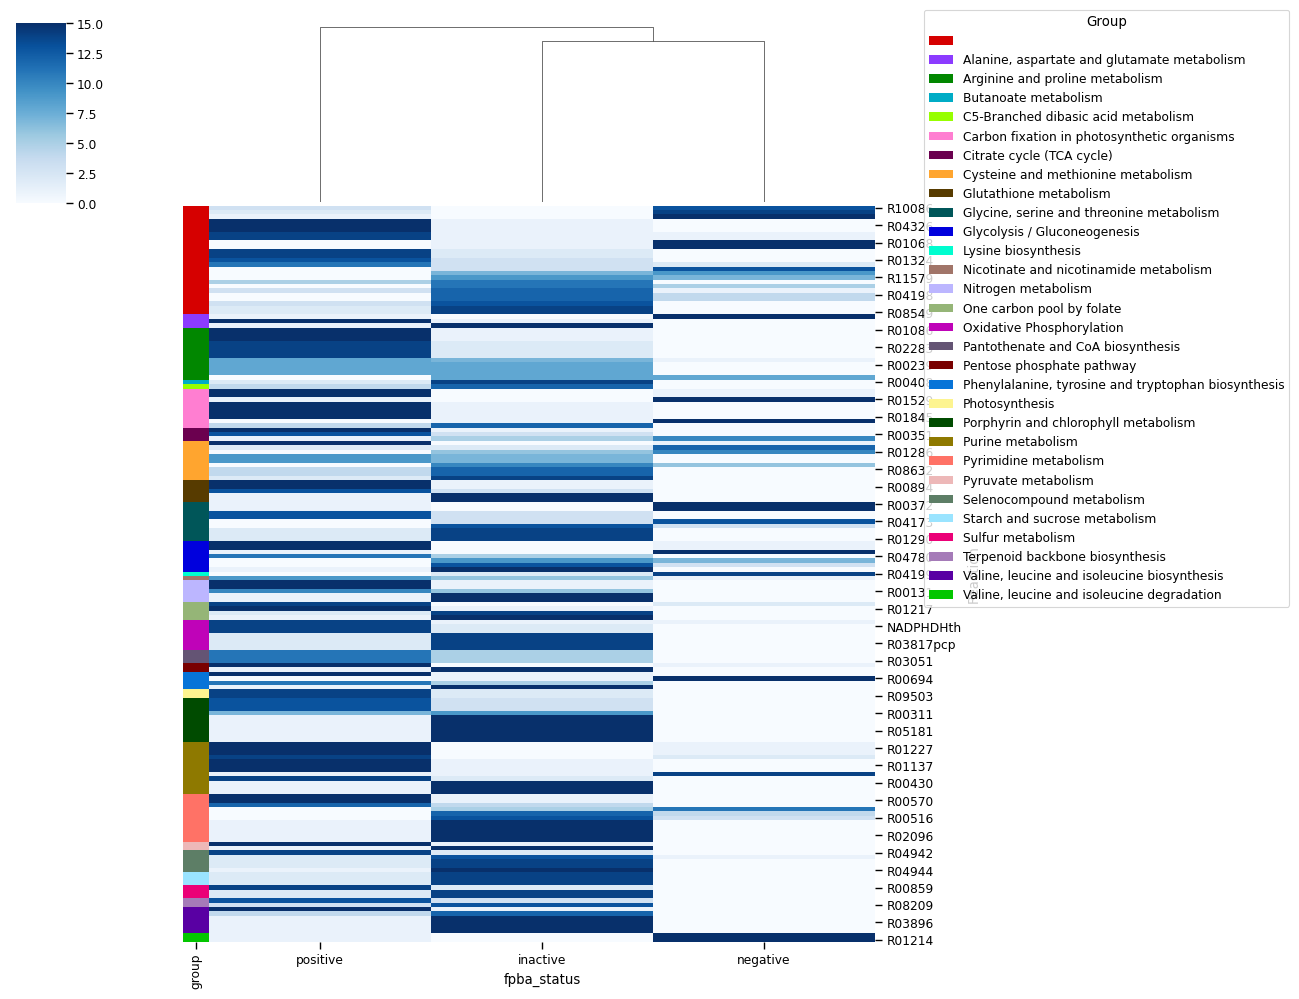

In [185]:
from matplotlib.patches import Patch

pdf = pfba_df.pivot_table(index='Reaction', columns='fpba_status', values='Uptake', aggfunc='nunique', fill_value=0)
pdf = pdf.loc[
    (pdf.inactive != 16) &
    (pdf.positive != 16) &
    (pdf.negative != 16) &
    ~pdf.index.to_series().str.contains('trans', case=False) & 
    ~pdf.index.to_series().isin(exchange_ids)     
]

cols = ['inactive', 'negative', 'positive',]
#cols = ['negative', 'positive',]
pdf['group'] = pdf.index.to_series().map(_get_group)
pdf = pdf.sort_values(['group'] + cols)
glist = pdf['group']

# glist = pdf.index.to_series().map(_get_group)
# glist = glist.sort_values()
# pdf = pdf.reindex(index=glist.index)

lut = dict(zip(glist.unique(), sns.color_palette(cc.glasbey, glist.nunique())))
sns.clustermap(pdf[cols], cmap='Blues', row_colors=glist.map(lut), row_cluster=False)
#sns.clustermap(pdf[cols], cmap='Blues', row_colors=glist.map(lut))
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Group',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

In [186]:
pdf.shape

(169, 4)

In [187]:
len(df_paths_list)

16

In [188]:
df_paths = pd.concat(df_paths_list)


In [189]:
#df_paths['Reactant'] = df_paths.Product.shift()
#df_paths.loc[df_paths.Index.isin([1]), 'Reactant'] = df_paths.loc[df_paths.Index.isin([1]), 'Product']

In [190]:
top_groups = df_paths.groupby(['Uptake', 'Group']).size().reset_index().Group.value_counts().head(12).index.to_series()
top_groups = top_groups[~top_groups.isin(['', 'Transport'])]
top_groups.shape

(11,)

In [191]:
from bokeh.palettes import all_palettes
gpallete = all_palettes['Set3'][10]
group_colors = dict(zip(top_groups, gpallete)) 
group_colors['Other'] = '#cccccc'
group_colors
df_paths['group_color'] = df_paths.Group.map(group_colors)
df_paths['group_color'] = df_paths['group_color'].fillna(group_colors['Other'])

In [192]:
df_paths.groupby(['Uptake'])['path_id'].nunique()

Uptake
AmmoniaEX         76
CyanateEX         35
GlutathioneEX     65
GlycineEX         38
GuanineEX         34
GuanosineEX       34
L_AlanineEX      133
L_ArginineEX      34
L_AspartateEX     81
L_CystineEX       34
L_GlutamateEX     90
L_GlutamineEX    215
L_LeucineEX       34
L_SerineEX        81
L_ValineEX        34
UreaEX            35
Name: path_id, dtype: int64

In [193]:
df_paths.columns


Index(['path_id', 'Index', 'Uptake', 'Reactant', 'Product', 'Reaction', 'Name',
       'Flux', 'Definition', 'Percent_Production', 'Group', 'group_color'],
      dtype='object')

In [321]:
df_paths.nunique()


path_id                215
Index                   51
Uptake                  16
Reactant               154
Product                173
Reaction               208
Name                   207
Flux                  1060
Definition             208
Percent_Production     649
Group                   36
group_color             11
Line_width            1060
Source                 154
Target                 173
Source1                163
dtype: int64

In [194]:
df_paths.groupby(
    ['Reactant', 'Product', 'Reaction', 'Name', 'Definition']).size().reset_index().nlargest(n=30, columns=0)
#sort_values(0, ascending=False)


,Reactant,Product,Reaction,Name,Definition,0
286,NADH,NAD+,R10221,R10221,6_Phospho_D_gluconate[c] + NAD[c] <=> CO2[c] + D_Ribulose_5_phosphate[c] + H[c] + NADH[c],597
128,CoA,NADH,R00209,pyruvate:NAD+ 2-oxidoreductase,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],575
43,ADP,ATP,R00086th,ATP synthetase(thylakoid),3.0 ADP[c] + 14.0 H[th] + 3.0 Orthophosphate[c] --> 3.0 ATP[c] + 3.0 H2O[c] + 14.0 H[c],479
22,4-Phospho-L-aspartate,L-Aspartate 4-semialdehyde,R02291,L-Aspartate-4-semialdehyde:NADP+ oxidoreductase,L_Aspartate_4_semialdehyde[c] + NADP[c] + Orthophosphate[c] <=> 4_Phospho_L_aspartate[c] + H[c] + NADPH[c],471
185,L-Aspartate,4-Phospho-L-aspartate,R00480,ATP:L-aspartate 4-phosphotransferase,ATP[c] + L_Aspartate[c] <=> 4_Phospho_L_aspartate[c] + ADP[c],459
196,L-Aspartate 4-semialdehyde,L-Homoserine,R01775,R01775,L_Homoserine[c] + NADP[c] <=> H[c] + L_Aspartate_4_semialdehyde[c] + NADPH[c],458
201,L-Cysteine,O-Acetyl-L-serine,R04859,R04859,H[c] + O_Acetyl_L_serine[c] + Thioredoxin[c] + Thiosulfate[c] <=> Acetate[c] + L_Cysteine[c] + Sulfite[c] + Thioredoxin_disulfide[c],452
272,NAD+,Acetyl_CoA[c],R00209,pyruvate:NAD+ 2-oxidoreductase,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],448
83,Acetyl_CoA[c],ADP,R00742,Acetyl-CoA:carbon-dioxide ligase,ATP[c] + Acetyl_CoA[c] + HCO3_[c] + H[c] --> ADP[c] + Malonyl[c] + Orthophosphate[c],443
325,Thioredoxin,3-Phosphoadenylyl sulfate,R02021,"adenosine 3,5-bisphosphate,sulfite:oxidized-thioredoxin oxidoreductase",3_Phosphoadenylyl_sulfate[c] + Thioredoxin[c] --> Adenosine_3_5_bisphosphate[c] + Sulfite[c] + Thioredoxin_disulfide[c],369


In [195]:
df_paths.groupby(
    ['Reaction', 'Name', 'Definition']).size().reset_index().nlargest(n=30, columns=0)
#sort_values(0, ascending=False)


,Reaction,Name,Definition,0
15,R00209,pyruvate:NAD+ 2-oxidoreductase,CoA[c] + NAD[c] + Pyruvate[c] --> Acetyl_CoA[c] + CO2[c] + H[c] + NADH[c],1055
173,R04859,R04859,H[c] + O_Acetyl_L_serine[c] + Thioredoxin[c] + Thiosulfate[c] <=> Acetate[c] + L_Cysteine[c] + Sulfite[c] + Thioredoxin_disulfide[c],759
116,R02021,"adenosine 3,5-bisphosphate,sulfite:oxidized-thioredoxin oxidoreductase",3_Phosphoadenylyl_sulfate[c] + Thioredoxin[c] --> Adenosine_3_5_bisphosphate[c] + Sulfite[c] + Thioredoxin_disulfide[c],747
49,R00742,Acetyl-CoA:carbon-dioxide ligase,ATP[c] + Acetyl_CoA[c] + HCO3_[c] + H[c] --> ADP[c] + Malonyl[c] + Orthophosphate[c],712
206,R10221,R10221,6_Phospho_D_gluconate[c] + NAD[c] <=> CO2[c] + D_Ribulose_5_phosphate[c] + H[c] + NADH[c],597
30,R00480,ATP:L-aspartate 4-phosphotransferase,ATP[c] + L_Aspartate[c] <=> 4_Phospho_L_aspartate[c] + ADP[c],487
4,R00086th,ATP synthetase(thylakoid),3.0 ADP[c] + 14.0 H[th] + 3.0 Orthophosphate[c] --> 3.0 ATP[c] + 3.0 H2O[c] + 14.0 H[c],479
129,R02291,L-Aspartate-4-semialdehyde:NADP+ oxidoreductase,L_Aspartate_4_semialdehyde[c] + NADP[c] + Orthophosphate[c] <=> 4_Phospho_L_aspartate[c] + H[c] + NADPH[c],471
103,R01775,R01775,L_Homoserine[c] + NADP[c] <=> H[c] + L_Aspartate_4_semialdehyde[c] + NADPH[c],458
118,R02026,O-acetyl-L-homoserine acetate-lyase (L-homocysteine forming),H[c] + O_Acetyl_L_homoserine[c] + Thioredoxin[c] + Thiosulfate[c] --> Acetate[c] + L_Homocysteine[c] + Sulfite[c] + Thioredoxin_disulfide[c],431


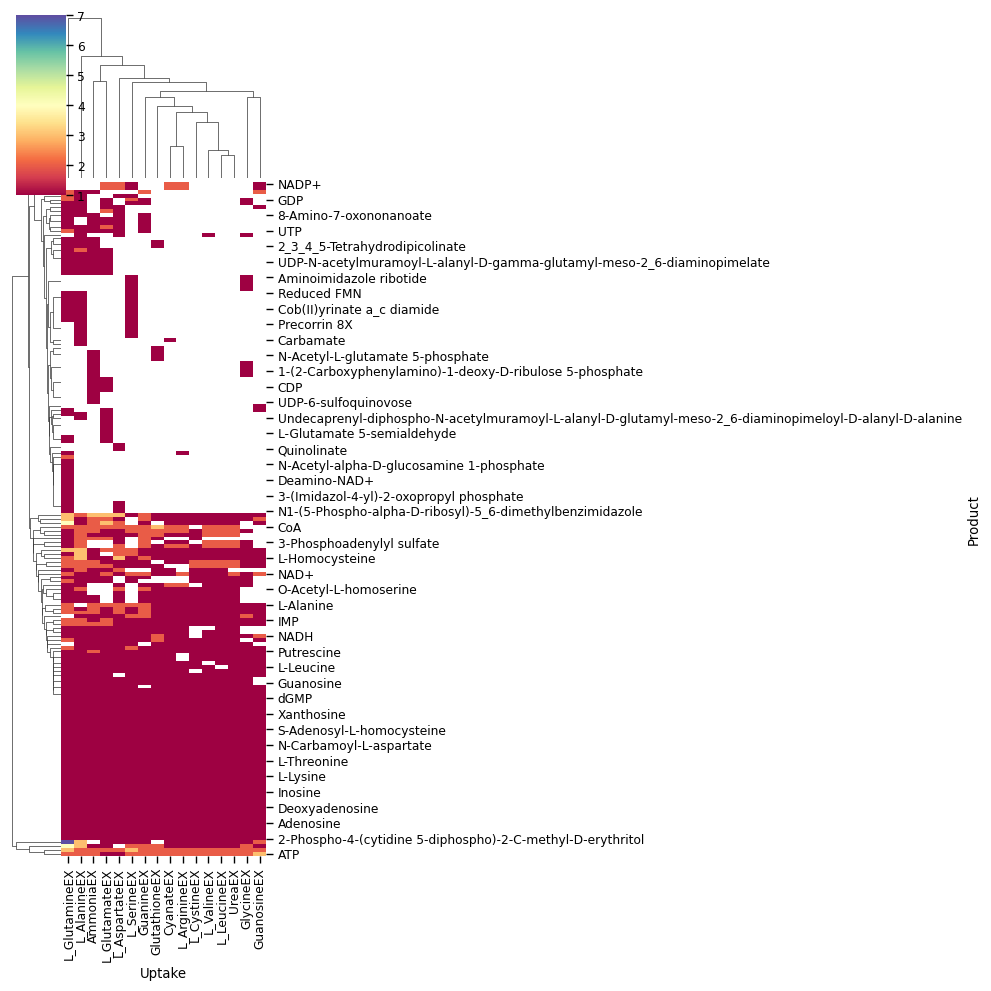

In [318]:
pdf = df_paths.pivot_table(columns='Uptake', index='Product', values='Reaction', aggfunc='nunique', fill_value=0)

sns.clustermap(pdf, mask=(pdf==0), cmap='Spectral')


In [324]:
df_paths.Reaction.str.contains('trans', case=False).sum()

0

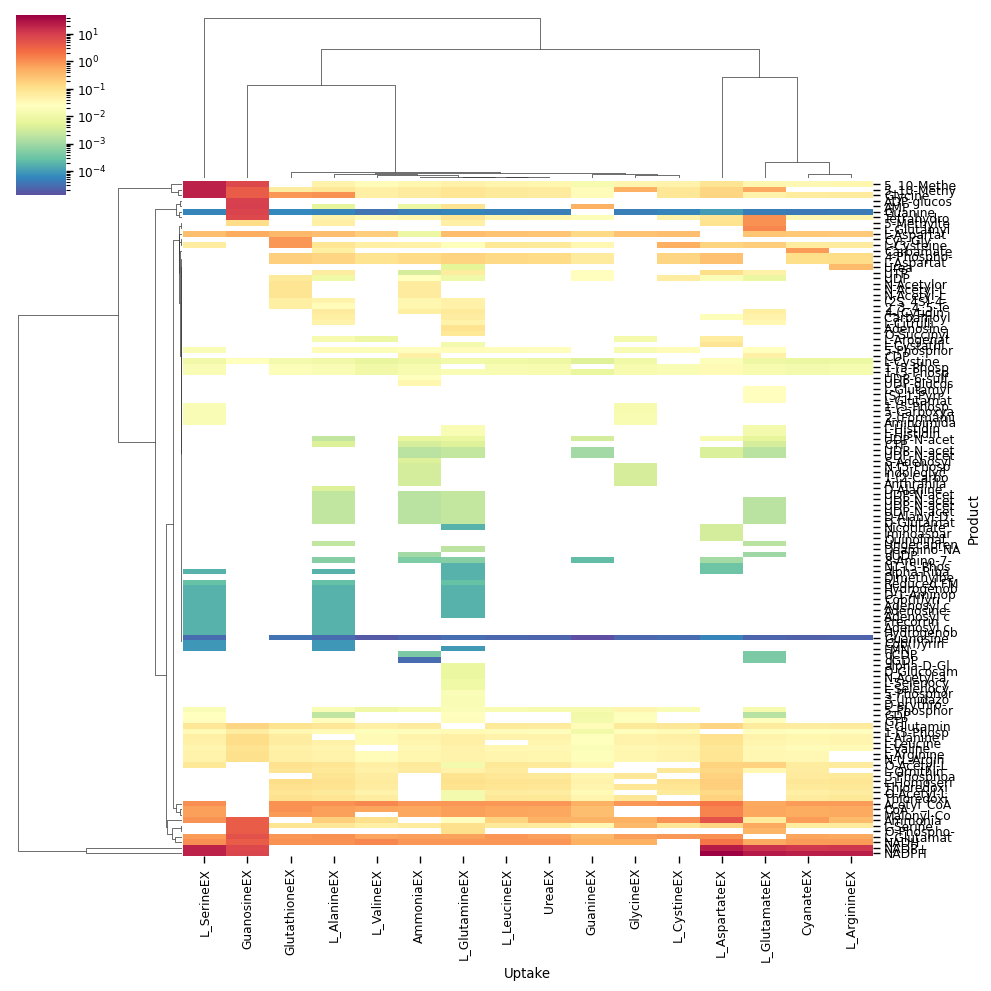

In [325]:

pdf = df_paths.pivot_table(columns='Uptake', index='Product', values='Flux', aggfunc='max', fill_value=0)
sel = (pdf == 0).sum(axis=1) > 0

sns.clustermap(
    pdf.loc[sel], mask=(pdf.loc[sel]==0), cmap='Spectral_r', norm=LogNorm(),
    yticklabels= pdf.loc[sel].index.str.slice(0, 10),
    #figsize=(10,20),

              )

In [198]:
pdf

Uptake,AmmoniaEX,CyanateEX,GlutathioneEX,GlycineEX,GuanineEX,GuanosineEX,L_AlanineEX,L_ArginineEX,L_AspartateEX,L_CystineEX,L_GlutamateEX,L_GlutamineEX,L_LeucineEX,L_SerineEX,L_ValineEX,UreaEX
Product,,,,,,,,,,,,,,,,
(2S_4S)-4-Hydroxy-2_3_4_5-tetrahydrodipicolinate,0.039219,0.000000,0.054664,0.000000,0.000000,0.000000,0.046384,0.000000,0.000000,0.000000,0.000000,0.048563,0.000000,0.000000,0.000000,0.000000
(S)-1-Pyrroline-5-carboxylate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025861,0.000000,0.000000,0.000000,0.000000,0.000000
(S)-Dihydroorotate,0.008946,0.008011,0.012469,0.009234,0.004782,0.025009,0.010581,0.008613,0.020139,0.010581,0.008837,0.011078,0.009449,0.010810,0.006808,0.008946
1-(2-Carboxyphenylamino)-1-deoxy-D-ribulose 5-phosphate,0.003465,0.000000,0.000000,0.003577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1-(5-Phospho-D-ribosyl)-5-amino-4-imidazolecarboxylate,0.000000,0.000000,0.000000,0.014551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017035,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dGMP,0.000026,0.000023,0.000036,0.000027,0.000014,0.000072,0.000030,0.000025,0.000058,0.000030,0.000025,0.000032,0.000027,0.000031,0.000020,0.000026
dTMP,0.000949,0.000850,0.001323,0.000980,0.000508,0.002654,0.001123,0.000914,0.002137,0.001123,0.000938,0.001176,0.001003,0.001147,0.000723,0.000949
dUDP,0.000980,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000968,0.000000,0.000000,0.000000,0.000000,0.000000


In [315]:
top_reactions = df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].nlargest(n=1000, columns='Flux').Reaction.unique()

In [200]:
top_reactions = df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].nlargest(n=300, columns='Flux').Reaction.unique()

In [316]:
(df_paths.loc[~df_paths.Reaction.str.contains('trans', case=False)].groupby('Product').Uptake.nunique() > 1).sum()

149

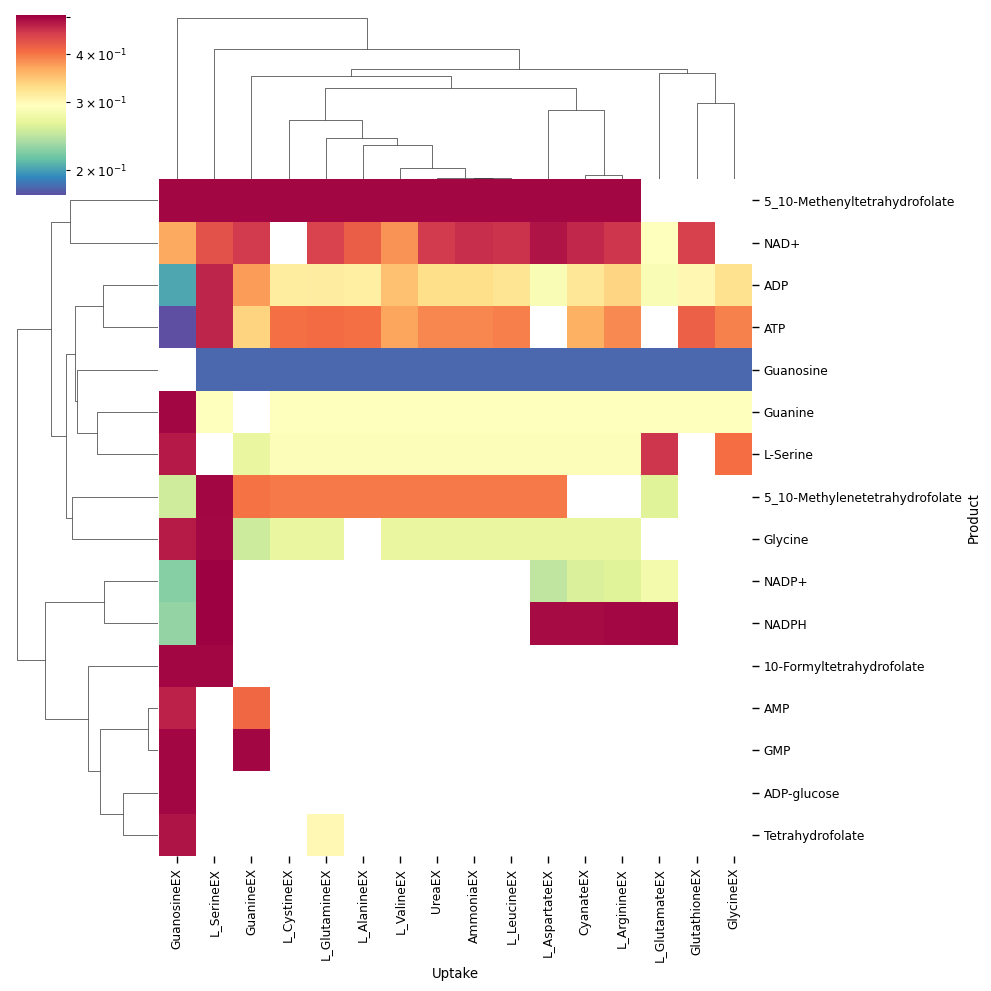

In [317]:
sns.set_context('paper')
pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)].pivot_table(columns='Uptake', index=['Product',#'Name'
                                                                                              ], values='Percent_Production', aggfunc='max', fill_value=0)
sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', norm=LogNorm(),
    figsize=(10,10),
    yticklabels= pdf.index.str.slice(0, 30),

              )

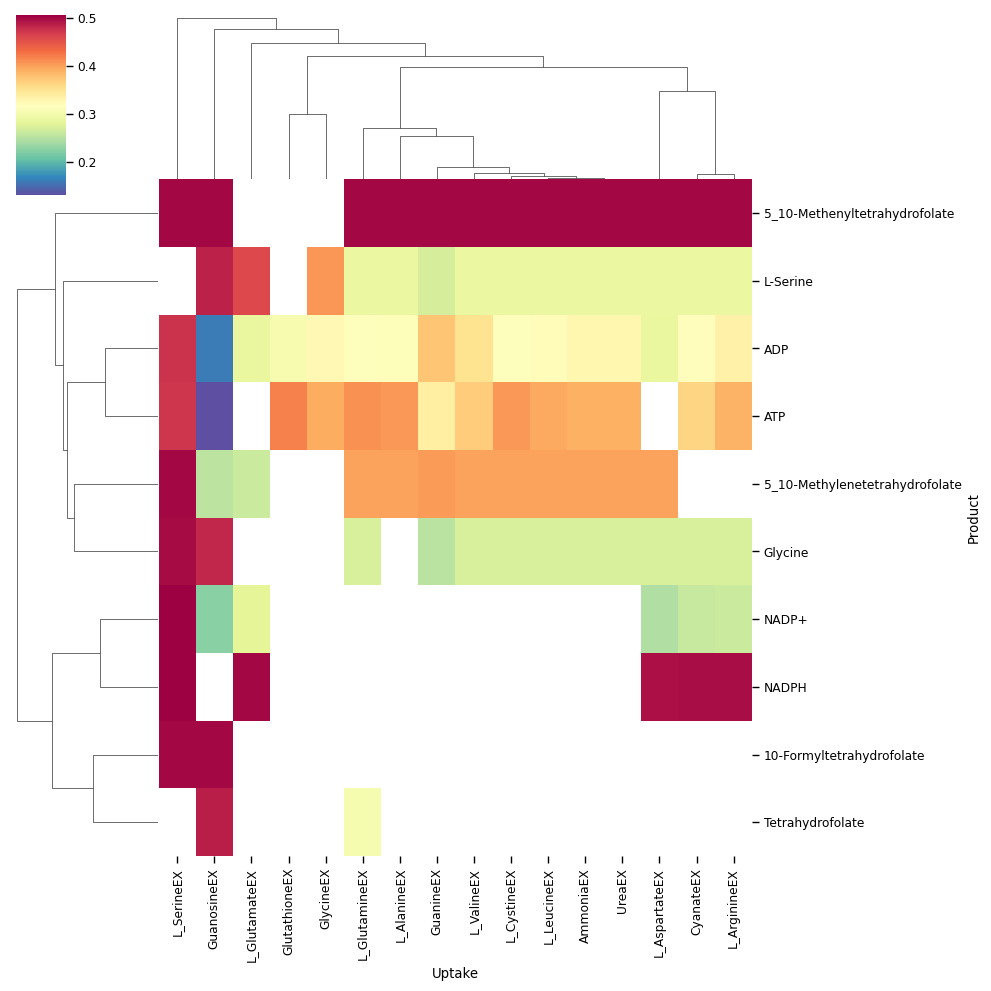

In [203]:
sns.set_context('paper')
pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)
                  ].pivot_table(columns='Uptake', 
                                index=['Product',#'Name'
                                      ], values='Percent_Production', aggfunc='max', fill_value=0)
sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', #norm=LogNorm(),
    figsize=(10,10),
    #yticklabels= pdf.index.str.slice(0, 30),

              )

In [204]:
group_colors

{'Glycine, serine and threonine metabolism': '#8dd3c7',
 'Valine, leucine and isoleucine degradation': '#ffffb3',
 'Terpenoid backbone biosynthesis': '#bebada',
 'Pyrimidine metabolism': '#fb8072',
 'Purine metabolism': '#80b1d3',
 'Porphyrin and chlorophyll metabolism': '#fdb462',
 'Alanine, aspartate and glutamate metabolism': '#b3de69',
 'Nitrogen metabolism': '#fccde5',
 'Lysine biosynthesis': '#d9d9d9',
 'Histidine metabolism': '#bc80bd',
 'Other': '#cccccc'}

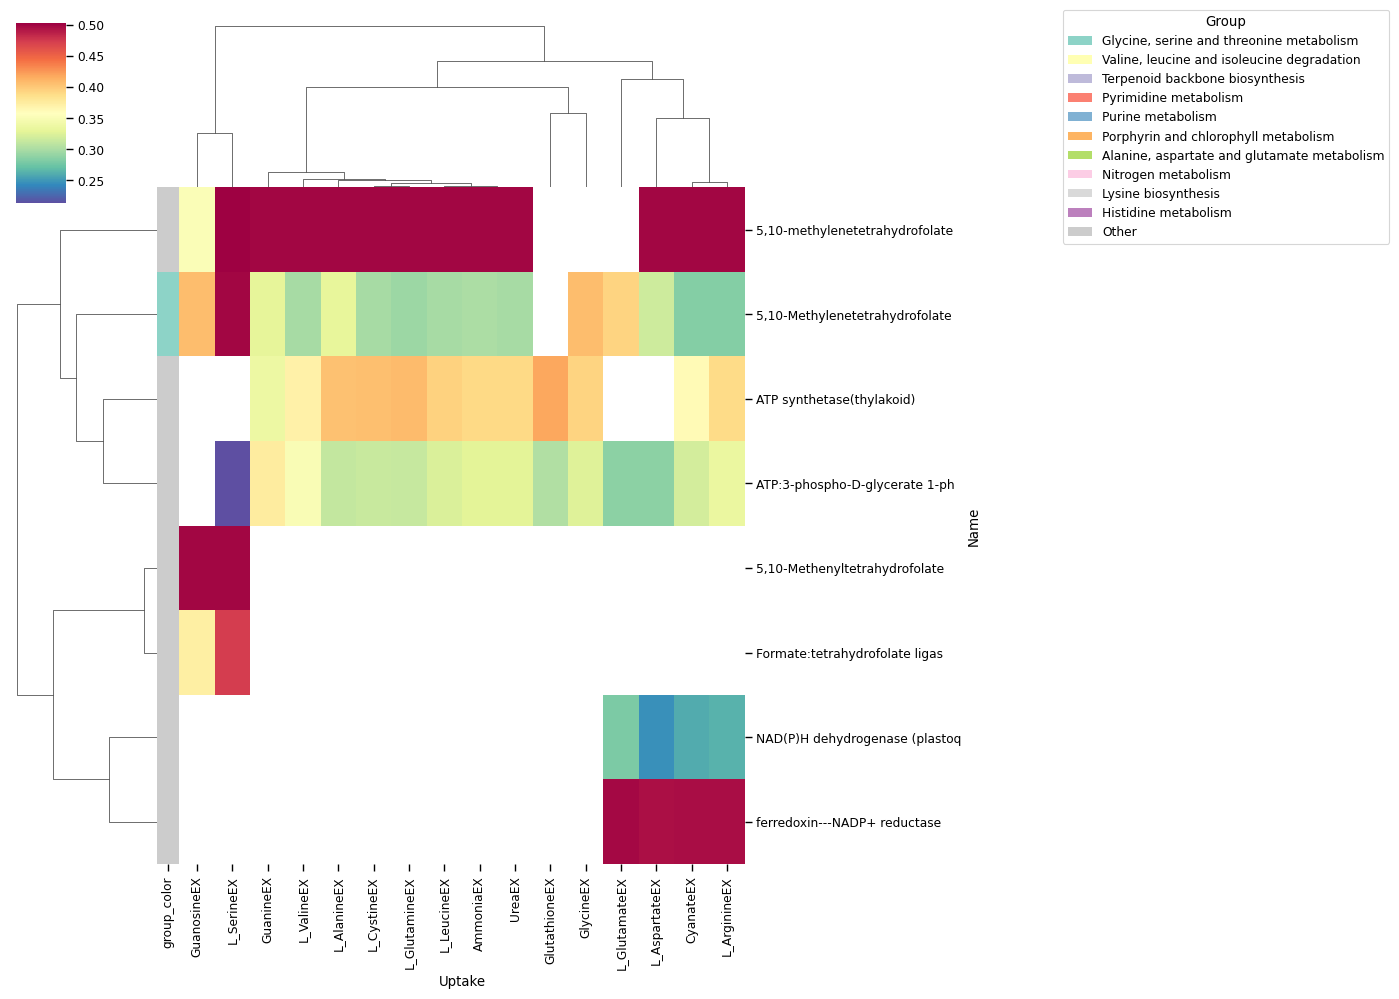

In [205]:
from matplotlib.patches import Patch

pdf = df_paths.loc[df_paths.Reaction.isin(top_reactions)
                  ].pivot_table(columns='Uptake', index=[#'Product',
    'Name'], values='Percent_Production', aggfunc='mean', fill_value=0)
row_colors = df_paths.groupby('Name').group_color.first()

sns.clustermap(
    pdf, mask=(pdf==0), cmap='Spectral_r', #norm=LogNorm(),
    yticklabels= pdf.index.str.slice(0, 30),
    row_colors=row_colors[pdf.index]

              )

handles = [Patch(facecolor=group_colors[name]) for name in group_colors]
plt.legend(handles, group_colors, title='Group',
           bbox_to_anchor=(1.4, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')


In [233]:
df_paths

,path_id,Index,Uptake,Reactant,Product,Reaction,Name,Flux,Definition,Percent_Production,Group,group_color,Line_width,Source,Target
0,1,1,GuanosineEX,Guanosine,GMP,R01227,Guanosine 5-monophosphate phosphohydrolase,10.557644,GMP[c] + H2O[c] <=> Guanosine[c] + Orthophosphate[c],0.499943,Purine metabolism,#80b1d3,5.999427,Guanosine,GMP
1,1,2,GuanosineEX,GMP,AMP,R01230,Xanthosine-5-phosphate:ammonia ligase,2.303622,ATP[c] + Ammonia[c] + Xanthosine_5_phosphate[c] <=> AMP[c] + Diphosphate[c] + GMP[c],0.110290,Purine metabolism,#80b1d3,2.102903,GMP,AMP
2,1,3,GuanosineEX,AMP,ATP,R01049,ATP:D-ribose-5-phosphate diphosphotransferase,8.126892,ATP[c] + D_Ribose_5_phosphate[c] <=> 5_Phospho_alpha_D_ribose_1_diphosphate[c] + AMP[c],0.140829,Pentose phosphate pathway,#cccccc,2.408287,AMP,ATP
3,1,4,GuanosineEX,ATP,ADP-glucose,R00948,ATP:alpha-D-glucose-1-phosphate adenylyltransferase,9.488995,ATP[c] + D_Glucose_1_phosphate[c] --> ADP_glucose[c] + Diphosphate[c],0.500000,Starch and sucrose metabolism,#cccccc,6.000000,ATP,ADP-glucose
4,1,5,GuanosineEX,ADP-glucose,ADP,R02421,"ADP-glucose:1,4-alpha-D-glucan 4-alpha-D-glucosyltransferase",9.488995,ADP_glucose[c] --> ADP[c] + Amylose[c],0.202860,Starch and sucrose metabolism,#cccccc,3.028595,ADP-glucose,ADP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,34,18,GuanineEX,Acetyl_CoA[c],ADP,R00742,Acetyl-CoA:carbon-dioxide ligase,0.310416,ATP[c] + Acetyl_CoA[c] + HCO3_[c] + H[c] --> ADP[c] + Malonyl[c] + Orthophosphate[c],0.012718,Pyruvate metabolism,#cccccc,1.127183,Acetyl_CoA[c],ADP
797,34,19,GuanineEX,ADP,ATP,R00086th,ATP synthetase(thylakoid),8.528579,3.0 ADP[c] + 14.0 H[th] + 3.0 Orthophosphate[c] --> 3.0 ATP[c] + 3.0 H2O[c] + 14.0 H[c],0.336723,Photosynthesis,#cccccc,4.367230,ADP,ATP
798,34,20,GuanineEX,ATP,AMP,R01049,ATP:D-ribose-5-phosphate diphosphotransferase,0.464833,ATP[c] + D_Ribose_5_phosphate[c] <=> 5_Phospho_alpha_D_ribose_1_diphosphate[c] + AMP[c],0.412005,Pentose phosphate pathway,#cccccc,5.120055,ATP,AMP
799,34,21,GuanineEX,AMP,Xanthosine 5-phosphate,R01230,Xanthosine-5-phosphate:ammonia ligase,0.440509,ATP[c] + Ammonia[c] + Xanthosine_5_phosphate[c] <=> AMP[c] + Diphosphate[c] + GMP[c],0.500000,Purine metabolism,#80b1d3,6.000000,AMP,Xanthosine 5-phosphate


In [245]:
#df_paths['weight'] = df_paths['Flux']
# from Daniel S. notebook
thickness_factor = 7
df_paths['Line_width'] = thickness_factor*np.abs(df_paths['Flux']) /max(np.abs(df_paths['Flux'])) # Computes normalized flux vector for drawing network
#df_paths['Line_width'] = (np.abs(df_paths['Flux']) +0.1) *10


G = nx.from_pandas_edgelist(df_paths, source='Reactant', target='Product', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')

In [247]:
df_paths['Source'] = df_paths['Reactant']
df_paths['Target'] = df_paths['Product']


In [249]:
df_paths.groupby(['Reaction', 'Group']).size().reset_index().Group.value_counts().head(10)

Purine metabolism                                      26
Pyrimidine metabolism                                  25
                                                       16
Porphyrin and chlorophyll metabolism                   15
Cysteine and methionine metabolism                     14
Arginine and proline metabolism                        14
Glycine, serine and threonine metabolism               13
Phenylalanine, tyrosine and tryptophan biosynthesis     8
Nicotinate and nicotinamide metabolism                  7
Lysine biosynthesis                                     6
Name: Group, dtype: int64

In [250]:
top_groups = df_paths.groupby(['Uptake', 'Group']).size().reset_index().Group.value_counts().head(12).index.to_series()
top_groups = top_groups[~top_groups.isin(['', 'Transport'])]
top_groups.shape

(11,)

In [251]:
df_paths.head()

,path_id,Index,Uptake,Reactant,Product,Reaction,Name,Flux,Definition,Percent_Production,Group,group_color,Line_width,Source,Target
0,1,1,GuanosineEX,Guanosine,GMP,R01227,Guanosine 5-monophosphate phosphohydrolase,10.557644,GMP[c] + H2O[c] <=> Guanosine[c] + Orthophosphate[c],0.499943,Purine metabolism,#80b1d3,1.548209,Guanosine,GMP
1,1,2,GuanosineEX,GMP,AMP,R01230,Xanthosine-5-phosphate:ammonia ligase,2.303622,ATP[c] + Ammonia[c] + Xanthosine_5_phosphate[c] <=> AMP[c] + Diphosphate[c] + GMP[c],0.110290,Purine metabolism,#80b1d3,0.337811,GMP,AMP
2,1,3,GuanosineEX,AMP,ATP,R01049,ATP:D-ribose-5-phosphate diphosphotransferase,8.126892,ATP[c] + D_Ribose_5_phosphate[c] <=> 5_Phospho_alpha_D_ribose_1_diphosphate[c] + AMP[c],0.140829,Pentose phosphate pathway,#cccccc,1.191755,AMP,ATP
3,1,4,GuanosineEX,ATP,ADP-glucose,R00948,ATP:alpha-D-glucose-1-phosphate adenylyltransferase,9.488995,ATP[c] + D_Glucose_1_phosphate[c] --> ADP_glucose[c] + Diphosphate[c],0.500000,Starch and sucrose metabolism,#cccccc,1.391499,ATP,ADP-glucose
4,1,5,GuanosineEX,ADP-glucose,ADP,R02421,"ADP-glucose:1,4-alpha-D-glucan 4-alpha-D-glucosyltransferase",9.488995,ADP_glucose[c] --> ADP[c] + Amylose[c],0.202860,Starch and sucrose metabolism,#cccccc,1.391499,ADP-glucose,ADP


In [252]:
from bokeh.palettes import all_palettes
gpallete = all_palettes['Set3'][10]
group_colors = dict(zip(top_groups, gpallete)) 
group_colors['Other'] = '#cccccc'
group_colors
df_paths['group_color'] = df_paths.Group.map(group_colors)
df_paths['group_color'] = df_paths['group_color'].fillna(group_colors['Other'])

In [329]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.layouts import gridplot
#tools='pan,wheel_zoom,box_select'
def _layout_func(x):
    f = nx.nx_agraph.pygraphviz_layout(x)
    return {k: np.asarray(f[k]) for k in f}

    

def _create_plot(df_paths, met1):
    # We could use figure here but don't want all the axes and titles
    df = df_paths.loc[df_paths.Uptake.isin([met1])]
    thickness_factor = 10
    #df['Line_width'] = thickness_factor*np.abs(df['Flux']) /np.max(np.abs(df['Flux'])) # Computes normalized flux vector for drawing network
    df['Line_width1'] = thickness_factor*np.sqrt((np.abs(df['Flux'])+ 1) /np.max(np.abs(df['Flux']))) # Computes normalized flux vector for drawing network

    met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    
    G = nx.from_pandas_edgelist(df, 
                                source='Source', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    dna_names = [i.name for i in dna_metabolites]
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(dna_names), 'Type'] = 'dna'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.isin([met_name]),'Type'] = 'Uptake'
    attr_df['label'] = attr_df.node.map(codes_df['code'])
    attr_df.loc[attr_df.node.isin([met_name]) & attr_df.label.isna(),'label'] = met_name

    
    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','dna', 'Other'], (list(all_palettes['Category10'][4]) + [None]))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=500, height=500, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               title=met_name)

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    #Add Labels
    attr_df['x'] = [x for x,y in graph.layout_provider.graph_layout.values()]
    attr_df['y'] = [y for x,y in graph.layout_provider.graph_layout.values()]
    [ [x,y] for x,y in graph.layout_provider.graph_layout.values()]
    x, y = zip(*graph.layout_provider.graph_layout.values())
    label_df = attr_df.loc[~attr_df['label'].isna()]
    
    source = ColumnDataSource(label_df[['x', 'y','label']])
    labels = LabelSet(x='x', y='y', text='label', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
    plot.renderers.append(labels)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8, line_width='Line_width1')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [330]:
from bokeh.plotting import figure
from bokeh import events
from bokeh.models import CustomJS, Div, Button
from bokeh.layouts import column, row

m = 'GlycineEX'
p = _create_plot(df_paths, m) 

# item_list = 
# legend = Legend(items=[
#     LegendItem(label="orange", renderers=[r], index=0),
#     LegendItem(label="red", renderers=[r], index=1),
# ])
# p.add_layout(legend)
# div = Div(width=400)
# layout = column(p, div)

# p.js_on_event(events.SelectionGeometry, CustomJS(args=dict(div=div), code="""
# div.text = "Selection! <p> <p>" + JSON.stringify(cb_obj.geometry, undefined, 2);
# """))

# show(layout)
show(p)

/tmp/ipykernel_70892/9388282.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Line_width1'] = thickness_factor*np.sqrt((np.abs(df['Flux'])+ 1) /np.max(np.abs(df['Flux']))) # Computes normalized flux vector for drawing network


In [331]:
from bokeh.io import output_file, show
output_file("aa_production.html")
plots = [_create_plot(df_paths, m) for m in df_paths.Uptake.unique()]
# put all the plots in a gridplot
p = gridplot(plots, ncols=4)


#plot.add_tools(HoverTool(tooltips=None))

show(p)

/tmp/ipykernel_70892/9388282.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Line_width1'] = thickness_factor*np.sqrt((np.abs(df['Flux'])+ 1) /np.max(np.abs(df['Flux']))) # Computes normalized flux vector for drawing network
/tmp/ipykernel_70892/9388282.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Line_width1'] = thickness_factor*np.sqrt((np.abs(df['Flux'])+ 1) /np.max(np.abs(df['Flux']))) # Computes normalized flux vector for drawing network
/tmp/ipykernel_70892/9388282.py:19: SettingW

In [307]:
df_paths.Target.value_counts().head(40)

ATP                                                           714
ADP                                                           696
NAD+                                                          658
NADH                                                          614
CoA                                                           598
Acetyl_CoA[c]                                                 544
L-Aspartate                                                   528
L-Glutamate                                                   479
L-Aspartate 4-semialdehyde                                    471
4-Phospho-L-aspartate                                         471
L-Cysteine                                                    461
L-Homoserine                                                  458
O-Acetyl-L-serine                                             452
Ammonia                                                       430
Thioredoxin                                                   405
Thioredoxi

In [218]:
from bokeh.plotting import reset_output
reset_output()

In [219]:
df_paths.to_excel('MED4_paths_to_ammonia.xlsx')

In [162]:
df_paths.head()

,path_id,Index,Uptake,Reactant,Product,Reaction,Name,Flux,Definition,Percent_Production,Group,group_color,Line_width,Source,Target
0,1,1,GuanosineEX,ATP,L-Glutamate,R00239,ATP:L-glutamate 5-phosphotransferase,0.179496,ATP[c] + L_Glutamate[c] --> ADP[c] + L_Glutamyl_5_phosphate[c],0.015867,Arginine and proline metabolism,#cccccc,1.158666,ATP,L-Glutamate
1,2,1,GuanosineEX,Tetrahydrofolate,Glycine,R00945,"5,10-Methylenetetrahydrofolate:glycine hydroxymethyltransferase",3.920271,5_10_Methylenetetrahydrofolate[c] + Glycine[c] + H2O[c] <=> L_Serine[c] + Tetrahydrofolate[c],0.480313,"Glycine, serine and threonine metabolism",#bc80bd,5.803125,Tetrahydrofolate,Glycine
2,3,1,GuanosineEX,ATP,L-Alanine,R03193,UDP-N-acetylmuramate:L-alanine ligase,0.005122,ATP[c] + L_Alanine[c] + UDP_N_acetylmuramate[c] --> ADP[c] + Orthophosphate[c] + UDP_N_acetylmuramoyl_L_alanine[c],0.015884,D-Glutamine and D-glutamate metabolism,#cccccc,1.158845,ATP,L-Alanine
3,4,1,GuanosineEX,ATP,meso-2_6-Diaminoheptanedioate,R02788,"UDP-N-acetylmuramoyl-L-alanyl-D-glutamate:(L)-meso-2,6-diaminoheptanedioate gamma-ligase",0.005122,ATP[c] + UDP_N_acetylmuramoyl_L_alanyl_D_glutamate[c] + meso_2_6_Diaminoheptanedioate[c] --> ADP[c] + Orthophosphate[c] + UDP_N_acetylmuramoyl_L_alanyl_D_gamma_glutamyl_meso_2_6_diaminopimelate[c],0.023358,Lysine biosynthesis,#8dd3c7,1.233580,ATP,meso-2_6-Diaminoheptanedioate
4,4,2,GuanosineEX,meso-2_6-Diaminoheptanedioate,L-Lysine,R00451,"meso-2,6-diaminoheptanedioate carboxy-lyase",0.104515,meso_2_6_Diaminoheptanedioate[c] --> CO2[c] + L_Lysine[c],0.360782,Lysine biosynthesis,#8dd3c7,4.607821,meso-2_6-Diaminoheptanedioate,L-Lysine


In [163]:
colors = all_palettes['Category20'][16]

In [164]:
sns.color_palette(colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451)]

In [165]:
lut = dict(zip(sorted(df_paths.Uptake.unique()), colors))

In [166]:
list(lut)

['AmmoniaEX',
 'CyanateEX',
 'GlutathioneEX',
 'GlycineEX',
 'GuanineEX',
 'GuanosineEX',
 'L_AlanineEX',
 'L_ArginineEX',
 'L_AspartateEX',
 'L_CystineEX',
 'L_GlutamateEX',
 'L_GlutamineEX',
 'L_LeucineEX',
 'L_SerineEX',
 'L_ValineEX',
 'UreaEX']

In [167]:
df_paths['uptake_color'] = df_paths.Uptake.map(lut)

In [168]:
df_paths[['Uptake','Reaction','uptake_color']].to_excel('amino_uptake_reactions_kegg.xlsx')

In [169]:
all_aa_reactions_df = pfba_df.loc[pfba_df.Reaction.isin(df_paths.Reaction) & np.abs(pfba_df.fluxes) > 1e-5]

In [170]:
all_aa_reactions_df['uptake_color'] = all_aa_reactions_df.Uptake.map(lut)

/tmp/ipykernel_70892/1963570828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_aa_reactions_df['uptake_color'] = all_aa_reactions_df.Uptake.map(lut)


In [91]:
all_aa_reactions_df['gid'] = all_aa_reactions_df.Reaction.map(lambda rid : [g.id for g in model.reactions.get_by_id(rid).genes])
all_aa_reactions_wgenes_df = all_aa_reactions_df.explode(column='gid')

/tmp/ipykernel_60479/991423849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_aa_reactions_df['gid'] = all_aa_reactions_df.Reaction.map(lambda rid : [g.id for g in model.reactions.get_by_id(rid).genes])


In [92]:
all_aa_reactions_wgenes_df

,Reaction,fluxes,reduced_costs,Uptake,fpba_status,Group,uptake_color,gid
4,R00355,0.532450,-2.0,GuanosineEX,positive,"Alanine, aspartate and glutamate metabolism",#98df8a,PMM0674
6,R00369,-0.120617,2.0,GuanosineEX,negative,"Alanine, aspartate and glutamate metabolism",#98df8a,PMM0919
7,R00485,0.025216,-2.0,GuanosineEX,positive,"Alanine, aspartate and glutamate metabolism",#98df8a,PMM0821
40,R00239,0.179496,-2.0,GuanosineEX,positive,Arginine and proline metabolism,#98df8a,PMM0590
40,R00239,0.179496,-2.0,GuanosineEX,positive,Arginine and proline metabolism,#98df8a,PMM0788
...,...,...,...,...,...,...,...,...
15825,R04859,-0.037501,2.0,GuanineEX,negative,,#2ca02c,PMM0642
15825,R04859,-0.037501,2.0,GuanineEX,negative,,#2ca02c,PMM0123
15825,R04859,-0.037501,2.0,GuanineEX,negative,,#2ca02c,PMM0407
15892,R10949,0.025111,-2.0,GuanineEX,positive,,#2ca02c,PMM0825


In [93]:
all_aa_reactions_df[['Reaction','uptake_color']].to_excel('amino_uptake_all_reactions_kegg.xlsx', index=False)

In [94]:
all_aa_reactions_wgenes_df[['gid','uptake_color']].dropna().drop_duplicates().to_excel('amino_uptake_all_genes_kegg.xlsx', index=False)

In [95]:
all_aa_reactions_wgenes_df = all_aa_reactions_wgenes_df.dropna(subset=['gid'])

In [104]:
all_aa_reactions_wgenes_df.dropna(subset='gid').pivot_table(
    index=['gid'], columns='Uptake', values='fluxes', aggfunc='max', fill_value=0
    ).to_csv('amino_uptake_all_genes_biocyc.csv', sep='\t')


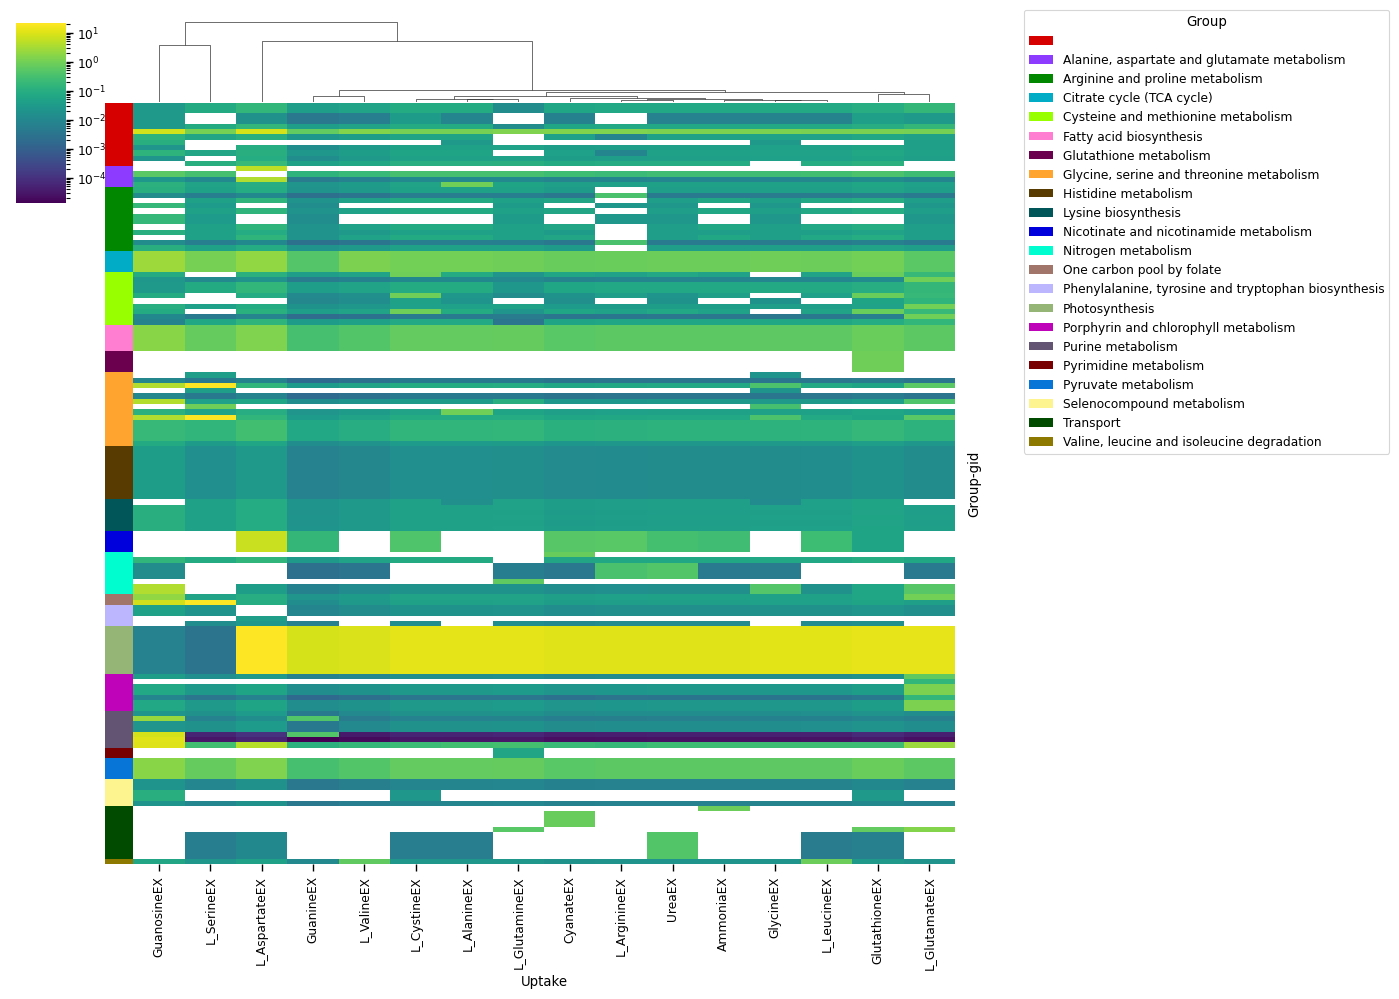

In [99]:
from matplotlib.patches import Patch

pdf = all_aa_reactions_wgenes_df.dropna(subset='gid').pivot_table(
    index=['Group', 'gid'], columns='Uptake', values='fluxes', aggfunc='max', fill_value=0)

cols = pdf.columns.to_list()
glist = pdf.index.get_level_values(0).to_series()

mask = np.abs(pdf) < 1e-5
lut = dict(zip(glist.unique(), sns.color_palette(cc.glasbey, glist.nunique())))
sns.clustermap(np.abs(pdf), cmap='viridis', 
               row_colors=glist.map(lut).values, 
               row_cluster=False, #center=0, 
               mask=mask,
                   yticklabels=False, #vmax=5, vmin=-5,
            dendrogram_ratio=0.1,
               norm=LogNorm(),
              )
#sns.clustermap(pdf[cols], cmap='Blues', row_colors=glist.map(lut))
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Group',
           bbox_to_anchor=(1.4, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

In [298]:
df_paths['Source1'] = df_paths['Source']
df_paths.loc[df_paths.Index == 1, 'Source1'] = df_paths.loc[df_paths.Index == 1, 'Source1']+ '_e'

In [301]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.layouts import gridplot
#tools='pan,wheel_zoom,box_select'
def _layout_func(x):
    f = nx.nx_agraph.pygraphviz_layout(x)
    return {k: np.asarray(f[k]) for k in f}

    

def _create_plot_all(df_paths):
    # We could use figure here but don't want all the axes and titles
    #df = df_paths.loc[df_paths.Uptake.isin([met1])]
    #met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    df = df_paths
    
    G = nx.from_pandas_edgelist(df, 
                                source='Source1', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    aa_names_so = [i.name+ '_e' for i in amino_acid_metabolites]
    
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.isin(aa_names_so),'Type'] = 'Uptake'

    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','Other'], (list(all_palettes['Category10'][3]) + [None]))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=600, height=600, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               #title=met_name
               )

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8) #, line_width='Line_width')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [302]:
p = _create_plot_all(df_paths)
show(p)

In [349]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.layouts import gridplot
#tools='pan,wheel_zoom,box_select'

    

def _create_plot_all(df_paths):
    # We could use figure here but don't want all the axes and titles
    df = df_paths.copy()
    thickness_factor = 1
    #df['Line_width'] = thickness_factor*np.abs(df['Flux']) /np.max(np.abs(df['Flux'])) # Computes normalized flux vector for drawing network
    lwidthmap = df.groupby('Reaction').Uptake.nunique()
    df['Line_width1'] = thickness_factor*np.sqrt(df['Reaction'].map(lwidthmap))

    #met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    df.loc[df.Index == 1, 'Source'] = df.loc[df.Index == 1, 'Source'] +'[e]'
    
    G = nx.from_pandas_edgelist(df, 
                                source='Source', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    dna_names = [i.name for i in dna_metabolites]
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(dna_names), 'Type'] = 'dna'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.str.endswith('[e]'),'Type'] = 'Uptake'
    attr_df['label'] = attr_df.node.map(codes_df['code'])
    attr_df.loc[attr_df.Type.isin(['Uptake']) & attr_df.label.isna(),'label'] = attr_df.loc[attr_df.Type.isin(['Uptake']) & attr_df.label.isna(),'node']

    
    attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','dna', 'Other'], (list(all_palettes['Category10'][4]) + [None]))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=1000, height=1000, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               title='all uptake')

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    #Add Labels
    attr_df['x'] = [x for x,y in graph.layout_provider.graph_layout.values()]
    attr_df['y'] = [y for x,y in graph.layout_provider.graph_layout.values()]
    [ [x,y] for x,y in graph.layout_provider.graph_layout.values()]
    x, y = zip(*graph.layout_provider.graph_layout.values())
    label_df = attr_df.loc[~attr_df['label'].isna()]
    
    source = ColumnDataSource(label_df[['x', 'y','label']])
    labels = LabelSet(x='x', y='y', text='label', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
    plot.renderers.append(labels)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8, line_width='Line_width1')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [350]:
output_file("aa_production_all.html")
p = _create_plot_all(df_paths)

show(p)

In [497]:
df_paths.to_excel('paths_to_aa_dna.xlsx')

In [498]:
df = df_paths.copy()

#met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
df.loc[df.Index == 1, 'Source'] = df.loc[df.Index == 1, 'Source'] +'[e]'

G = nx.from_pandas_edgelist(df, 
                            source='Source', target='Target', edge_attr=True, 
                        create_using=nx.MultiDiGraph, edge_key='Reaction')

In [515]:
from networkx.algorithms.community import greedy_modularity_communities
clusters = greedy_modularity_communities(G)
cluster_map = {n: cluster_id for cluster_id, cluster_set in enumerate(clusters, start=1) for n in cluster_set}

In [516]:
target2group_df = df_paths.groupby(['Target', 'Group'])['Uptake'].nunique().reset_index()
target2group_df['cluster_id'] = target2group_df['Target'].map(cluster_map)

In [523]:
target2group_df.groupby(['cluster_id', 'Group', ]).size().tail(50)

cluster_id  Group                                              
3           Phenylalanine, tyrosine and tryptophan biosynthesis     3
            Purine metabolism                                       1
            Pyrimidine metabolism                                   5
4                                                                   5
            Alanine, aspartate and glutamate metabolism             2
            Cysteine and methionine metabolism                      2
            Glutathione metabolism                                  4
            Glycine, serine and threonine metabolism                5
            Lysine biosynthesis                                     4
            Nicotinate and nicotinamide metabolism                  1
            Nitrogen metabolism                                     3
            Purine metabolism                                       2
            Pyrimidine metabolism                                   1
            Valine, leucin

In [524]:
from bokeh.models.graphs import NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import Circle, HoverTool, MultiLine
from bokeh.models import (BoxZoomTool, Circle, HoverTool, WheelZoomTool, PanTool, BoxSelectTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.layouts import gridplot
#tools='pan,wheel_zoom,box_select'
def _layout_func(G):
    A = nx.nx_agraph.to_agraph(G)
    for cluster_id, cluster_set in enumerate(clusters, start=1):
        B = A.add_subgraph(cluster_set, name="s1", rank="same")
        A.add_subgraph()
        for 
    f = nx.nx_agraph.pygraphviz_layout(x)
    return {k: np.asarray(f[k]) for k in f}

    

def _create_plot_all(df_paths):
    # We could use figure here but don't want all the axes and titles
    df = df_paths.copy()
    thickness_factor = 1
    #df['Line_width'] = thickness_factor*np.abs(df['Flux']) /np.max(np.abs(df['Flux'])) # Computes normalized flux vector for drawing network
    lwidthmap = df.groupby('Reaction').Uptake.nunique()
    df['Line_width1'] = thickness_factor*np.sqrt(df['Reaction'].map(lwidthmap))

    #met_name = df.loc[df.Index == 1, 'Source'].unique()[0]
    df.loc[df.Index == 1, 'Source'] = df.loc[df.Index == 1, 'Source'] +'[e]'
    
    G = nx.from_pandas_edgelist(df, 
                                source='Source', target='Target', edge_attr=True, 
                            create_using=nx.MultiDiGraph, edge_key='Reaction')
    attr_df = pd.DataFrame(G.nodes, columns=['node'])
    attr_df.index = attr_df.node
    attr_df['Type'] = 'Other'
    aa_names = [i.name for i in amino_acid_metabolites]
    dna_names = [i.name for i in dna_metabolites]
    attr_df.loc[attr_df.node.isin(aa_names), 'Type'] = 'aa'
    attr_df.loc[attr_df.node.isin(dna_names), 'Type'] = 'dna'
    attr_df.loc[attr_df.node.isin(['Ammonia']),'Type'] = 'Ammonia'
    attr_df.loc[attr_df.node.str.endswith('[e]'),'Type'] = 'Uptake'
    attr_df['label'] = attr_df.node.map(codes_df['code'])
    attr_df.loc[attr_df.Type.isin(['Uptake']) & attr_df.label.isna(),'label'] = attr_df.loc[attr_df.Type.isin(['Uptake']) & attr_df.label.isna(),'node']

    
    #attr_df['node_color'] = attr_df['Type'].map(dict(zip(['aa', 'Ammonia', 'Uptake','dna', 'Other'], (list(all_palettes['Category10'][4]) + [None]))))
    attr_df['cluster_id'] = attr_df['node'].map(cluster_map)
    attr_df['node_color'] = attr_df['cluster_id'].map(dict(zip(attr_df['cluster_id'].unique(), (list(all_palettes['Category20'][16])))))
    for i in ['node_color', 'Type']:
        nx.set_node_attributes(G, name=i, values=attr_df[i].to_dict())

    plot = Plot(width=1000, height=1000, #, x_range=Range1d(-2,2), y_range=Range1d(-2,2),
               title='all uptake')

    # Create a Bokeh graph from the NetworkX input using nx.spring_layout
    #graph = from_networkx(G, nx.spring_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spectral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.multipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.spiral_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.shell_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.planar_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.kamada_kawai_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.bipartite_layout, scale=1.5, center=(0,0))
    #graph = from_networkx(G, nx.fruchterman_reingold_layout, scale=1.5, center=(0,0))
    graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='dot')
    # [‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’
    #graph = from_networkx(G, nx.nx_agraph.pygraphviz_layout, prog='twopi')
    #graph = from_networkx(G, _layout_func)
    
    plot.renderers.append(graph)

    #Add Labels
    attr_df['x'] = [x for x,y in graph.layout_provider.graph_layout.values()]
    attr_df['y'] = [y for x,y in graph.layout_provider.graph_layout.values()]
    [ [x,y] for x,y in graph.layout_provider.graph_layout.values()]
    x, y = zip(*graph.layout_provider.graph_layout.values())
    label_df = attr_df.loc[~attr_df['label'].isna()]
    
    source = ColumnDataSource(label_df[['x', 'y','label']])
    labels = LabelSet(x='x', y='y', text='label', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
    plot.renderers.append(labels)

    # Blue circles for nodes, and light grey lines for edges
    graph.node_renderer.glyph = Circle(size=10, fill_color='node_color')
    graph.edge_renderer.glyph = MultiLine(line_color='group_color', line_alpha=0.8, line_width='Line_width1')
    #graph.edge_renderer.glyph = MultiLine(line_color="#cccccc", line_alpha=0.8, line_width=4)

    # green hover for both nodes and edges
    graph.node_renderer.hover_glyph = Circle(size=10, fill_color='#abdda4')
    graph.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=4)

    # When we hover over nodes, highlight adjecent edges too
    graph.selection_policy =  NodesAndLinkedEdges()
    graph.inspection_policy = EdgesAndLinkedNodes()

    node_hover_tool = HoverTool(tooltips=[("Product", "@index")])
    edge_hover_tool = HoverTool(tooltips=[
        ('Path', '@Reactant --> @Product'),
        #('Reaction', '@Reaction: @Name'),
        ('Definition', '@Definition'), 
        ('Group', '@Group'),
    ])

    plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool(), BoxSelectTool() )
    return plot



In [525]:
output_file("aa_production_all.html")
p = _create_plot_all(df_paths)

show(p)